# EDA (Exploratory Data Analysis)

When using a BERT model, we deal with two constraints: all sentences must be padded or truncated to a single, fixed length and the maximum sentence length is 512 tokens. This maximum length does impact training and evaluation speed, so it's wise to analyse our data to find a sweet spot, if possible.

Update 05/11/2021: our dataset

Update 03/11/2021: try SciBERT.

Update 02/11/2021: use new dataframe with concatenated titles and abstracts.

References:
* HuggingFace materials (https://huggingface.co/transformers/)
* Chris McCormick's Bert Tutorials (https://mccormickml.com/)
* Jay Alammar's post (https://jalammar.github.io/illustrated-bert/)


### Setup

In [72]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [73]:
!pip install transformers

In [74]:
import pandas as pd

df = pd.read_csv('/content/SLRdata_cleaned.csv', index_col=0)

### Analysing data

In [75]:
# Report the number of abstracts.
print('Number of training abstracts: {:,}\n'.format(df.shape[0]))

df.head(4)

Number of training abstracts: 75



,index_SLR,title,abstract,text,decision
0,134,Optimal control and optimization algorithm for...,"As we all know, big data and intelligent compu...",Optimal control and optimization algorithm for...,0
2,133,Reinforcement Learning for Placement Optimization,"In the past decade, computer systems and chips...",Reinforcement Learning for Placement Optimizat...,0
4,132,Securities Analysis and Portfolio Management U...,Financial services institutions are adopting a...,Securities Analysis and Portfolio Management U...,1
5,131,Optimización e inteligencia artificial para la...,Decision making is a transcendental process th...,Optimización e inteligencia artificial para la...,0


In [76]:
df.columns

Index(['index_SLR', 'title', 'abstract', 'text', 'decision'], dtype='object')

In [77]:
dataframe = df.loc[:, ['index_SLR', 'title', 'abstract', 'decision']]

In [78]:
dataframe.head()

,index_SLR,title,abstract,decision
0,134,Optimal control and optimization algorithm for...,"As we all know, big data and intelligent compu...",0
2,133,Reinforcement Learning for Placement Optimization,"In the past decade, computer systems and chips...",0
4,132,Securities Analysis and Portfolio Management U...,Financial services institutions are adopting a...,1
5,131,Optimización e inteligencia artificial para la...,Decision making is a transcendental process th...,0
6,129,Hybrid chaos optimization algorithm with artif...,Much research on Artificial Intelligence (AI) ...,0


In [79]:
dataframe.shape

(75, 4)

In [80]:
# Dataset.
dataframe[['abstract', 'decision']].groupby('decision').count()

,abstract
decision,
0,47
1,28


In [81]:
dataframe.decision.value_counts(normalize=True)

0    0.626667
1    0.373333
Name: decision, dtype: float64

In [82]:
# First abstract.
dataframe.abstract[0]

'As we all know, big data and intelligent computing have been widely used in information science, life science, computer science and intelligent control, intelligent robots, vehicle networking, space technology, marine development and other fields, especially in the future life science and medical field. This paper is based on a new digital optimal decision-making idea of intelligent signal processing and control. On the basis of extending non-digital signal processing and information prediction to signal processing and information prediction in the digital generalized information measurement space, and making full use of optimization algorithms such as digital filtering and frequency spectrum analysis, this article discusses in depth the intelligent optimal control of a class of non-stationary random processes in artificial intelligence, biomedicine, radio communication, automatic control and other scientific and technological fields. It provides a new theory, a new approach and an ef

In [83]:
t_abstracts = dataframe.abstract
t_labels = dataframe.decision

In [84]:
# Extract the abstracts and labels of our training+validation set as numpy ndarrays.
abstracts = t_abstracts.to_numpy()
labels = t_labels.to_numpy()

In [85]:
from transformers import AutoTokenizer, BertTokenizer

# Load the tokenizers
print('Loading tokenizers...\n')
scibert_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('   bert_tokenizer is type:', type(bert_tokenizer))

Loading tokenizers...

scibert_tokenizer is type: <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
   bert_tokenizer is type: <class 'transformers.models.bert.tokenization_bert.BertTokenizer'>


Comparing BERT and SciBERT tokens

In [86]:
text = abstracts[0]

# Split the sentence into tokens, with both BERT and SciBERT.
bert_tokens = bert_tokenizer.tokenize(text)
scibert_tokens = scibert_tokenizer.tokenize(text)

print('Abstract 0 contains {:,} WordPiece tokens.'.format(len(bert_tokens)))
print('Abstract 0 contains {:,} SentencePiece tokens.\n'.format(len(scibert_tokens)))

# Pad out the scibert list to be the same length.
while len(scibert_tokens) < len(bert_tokens):
    scibert_tokens.append("")

# Label the columns.
print('{:<12} {:<12}'.format("BERT", "SciBERT"))
print('{:<12} {:<12}'.format("----", "-------"))

# Display the first 50 tokens.
for i, tup in enumerate(zip(bert_tokens, scibert_tokens)):
    print('{:<12} {:<12}'.format(tup[0], tup[1]))
    if i > 50:
        break

Abstract 0 contains 189 WordPiece tokens.
Abstract 0 contains 187 SentencePiece tokens.

BERT         SciBERT     
----         -------     
as           as          
we           we          
all          all         
know         know        
,            ,           
big          big         
data         data        
and          and         
intelligent  intelligent 
computing    computing   
have         have        
been         been        
widely       widely      
used         used        
in           in          
information  information 
science      science     
,            ,           
life         life        
science      science     
,            ,           
computer     computer    
science      science     
and          and         
intelligent  intelligent 
control      control     
,            ,           
intelligent  intelligent 
robots       robots      
,            ,           
vehicle      vehicle     
networking   networking  
,            ,           
s

In [87]:
# Tokenize all abstracts

import numpy as np

# Tokenize all of the abstracts and map the tokens to their word IDs.
input_ids, input_ids_bert = [], []

# Record the length of each abstract.
lengths, lengths_bert = [], []

print('Tokenizing abstracts...')

for abst in abstracts:
  
  # Report progress.
  # if((len(input_ids) % 500) == 0 and not (len(input_ids) == 0)):
  #   print('Read {:,} abstracts.'.format(len(input_ids)))

  encoded_sent = scibert_tokenizer.encode_plus(abst,                      # Abstract to encode.
                                  add_special_tokens = True,)             # Add '[CLS]' and '[SEP]'
                                  #max_length=512,
                                  #truncation=True)
  encoded_sent_bert = bert_tokenizer.encode_plus(abst, add_special_tokens = True)

  # Add the encoded abstract to the list.    
  input_ids.append(encoded_sent.input_ids)
  input_ids_bert.append(encoded_sent_bert.input_ids)

  # Record the length.
  lengths.append(len(encoded_sent.input_ids))
  lengths_bert.append(len(encoded_sent_bert.input_ids))

print('\nDONE.')
print('\n{:>10,} abstracts.'.format(len(input_ids)))

Tokenizing abstracts...

DONE.

        75 abstracts.


In [88]:
print('{:>6,} included'.format(np.sum(labels)))
print('{:>6,} excluded'.format(len(labels) - np.sum(labels)))

    28 included
    47 excluded


In [89]:
print('SciBERT')
print('Min length: {:,} tokens'.format(min(lengths)))
print('Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))
print('BERT')
print('Min length: {:,} tokens'.format(min(lengths_bert)))
print('Max length: {:,} tokens'.format(max(lengths_bert)))
print('Median length: {:,} tokens'.format(np.median(lengths_bert)))

SciBERT
Min length: 89 tokens
Max length: 388 tokens
Median length: 202.0 tokens
BERT
Min length: 90 tokens
Max length: 402 tokens
Median length: 208.0 tokens


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


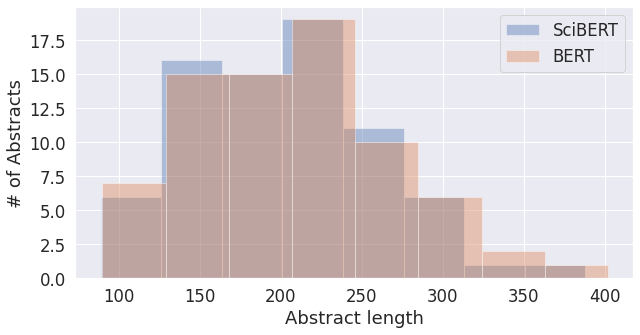

In [90]:
# Plot the distribution

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of abstract lengths.
sns.distplot(lengths, kde=False, rug=False, label='SciBERT')
#sns.displot(lengths, rug=False)

# Plot the distribution of abstract lengths.
sns.distplot(lengths_bert, kde=False, rug=False, label='BERT')

plt.xlabel('Abstract length')
plt.ylabel('# of Abstracts')
plt.legend(loc='upper right')

In [91]:
num_greater = sum(i > 512 for i in lengths)

# Compare this to the total number of training abstracts.
num_abstracts = len(lengths)
prcnt = float(num_greater) / float(num_abstracts)

print('{:,} of {:,} abstracts ({:.1%}) in the training/validation set are longer than 512 tokens.'.format(num_greater, num_abstracts, prcnt))

0 of 75 abstracts (0.0%) in the training/validation set are longer than 512 tokens.


In [92]:
# Number of abstracts; included vs. excluded.
num_pos = 0
num_neg = 0

# Iterate through the abstract lengths...
if num_greater > 0:
    for i, l in enumerate(lengths):
      if l > 512:
          if labels[i] == 1:
            num_pos += 1
          else:
            num_neg += 1

    # Report the total.
    print('{:,} of the examples ({:.1%}) contain an eligible abstract.'.format(num_pos, num_pos / (num_pos + num_neg)))


# Number of words plit by \" \"

In [93]:
def sorte(x, reverse = True):
  return dict(sorted(x.items(), key=lambda item: item[1], reverse=reverse))

t_abstracts_ls = [x.lower().split() for x in t_abstracts]
t_abstracts_label_ls = [(x.lower().split(), y) for x,y in zip(t_abstracts, t_labels)]

# Number of Words
all = {}
for ls in t_abstracts_ls:
  for x in ls:
    v = all.get(x, 0)
    all[x] = v+1

sorte(all)

  # Number of Words of labels (0,1)

def table(all):
  all = {}
  for ls, y in zip(t_abstracts_ls, t_labels):
    for x in ls:
      v = all.get((x, y) , 0)
      all[(x, y)] = v+1

  ps = []
  ng = []
  
  for x in sorte(all):
    if x[1] == 1:
      ps.append(x)
    else:
      ng.append(x)

  print(f"{'Label: 1':^27} | {'Label: 0':^25}")
  print(f"{'-'*60:^50}")
  k = 0
  for x,y in zip(ps, ng):
    k+=1
    if k > 20: break;
    print(f"{x[0]:^15}: {all[x]:^10} | {y[0]:^15}: {all[y]:^9}")

table(all)

         Label: 1           |         Label: 0         
------------------------------------------------------------
      the      :    331     |       the      :    497   
      of       :    208     |       of       :    377   
      and      :    174     |       and      :    311   
      to       :    124     |       in       :    197   
      in       :    114     |       to       :    191   
       a       :     74     |        a       :    154   
      is       :     57     |       is       :    106   
      for      :     52     |       for      :    91    
   decision    :     47     |      this      :    79    
  artificial   :     41     |   artificial   :    68    
      are      :     40     |       are      :    68    
     this      :     38     |       on       :    53    
 intelligence  :     37     |  optimization  :    53    
      on       :     37     |       as       :    52    
      by       :     30     |  intelligence  :    50    
     with      :     29     

# Number of words using the encoder bert


bert

0    47
1    28
Name: decision, dtype: int64
         Label: 1           |         Label: 0         
------------------------------------------------------------
      the      :    333     |       the      :    498   
      of       :    209     |        ,       :    393   
       .       :    208     |       of       :    378   
       ,       :    184     |        .       :    342   
      and      :    174     |       and      :    313   
      to       :    124     |       in       :    206   
      in       :    118     |       to       :    194   
       a       :     75     |        a       :    154   
       -       :     70     |        -       :    141   
   decision    :     65     |       is       :    108   
      is       :     57     |       for      :    92    
      for      :     52     |      this      :    80    
 intelligence  :     42     |        (       :    80    
    making     :     42     |        )       :    80    
  artificial   :     41     |   artifici

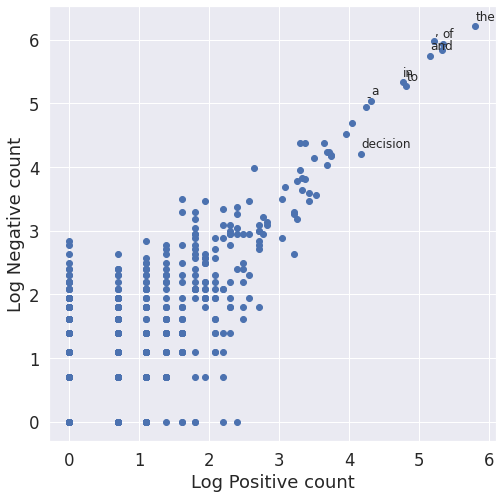

None

BY ps / 1 

     ps          text   ng
0   333           the  498
1   209            of  378
2   208             .  342
3   184             ,  393
4   174           and  313
5   124            to  194
6   118            in  206
7    75             a  154
8    70             -  141
9    65      decision   67
10   57            is  108
11   52           for   92
13   42        making   65
12   42  intelligence   66
14   41    artificial   69
15   40           are   69
16   40            on   56
17   38          this   80
18   34         based   35
19   33  optimization   63
20   31            by   36
21   31          data   32
22   29             )   80
23   29          with   45
25   28          that   46
24   28            an   38
26   27            as   52
27   27             (   80
28   26           can   24
29   26        system   44
30   25       process   27
31   25         model   14
32   25            be   26
33   22           ##s   40
34   21            it   33
35   21   

,text,variable,count
0,the,ps,333
701,the,ng,498


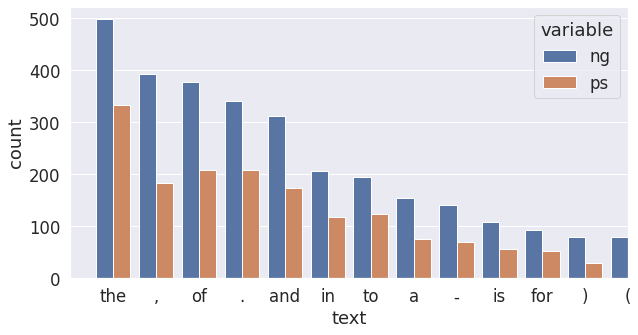

In [94]:
import matplotlib.pyplot as plt

def sorte(x, reverse = True):
  return dict(sorted(x.items(), key=lambda item: item[1], reverse=reverse))

t_abstracts_ls = [bert_tokenizer.tokenize(x) for x in t_abstracts]

print(t_labels.value_counts())
# Number of Words
all = {}
for ls in t_abstracts_ls:
  for x in ls:
    v = all.get(x, 0)
    all[x] = v+1


  # Number of Words of labels (0,1)

def table(all):
  all = {}
  for ls, y in zip(t_abstracts_ls, t_labels):
    for x in ls:
      v = all.get((x, y) , 0)
      all[(x, y)] = v+1

  ps = []
  ng = []
  
  for x in sorte(all):
    if x[1] == 1:
      ps.append(x)
    else:
      ng.append(x)
  

  print(f"{'Label: 1':^27} | {'Label: 0':^25}")
  print(f"{'-'*60:^50}")
  k = 0
  for x,y in zip(ps, ng):
    k+=1
    if k > 20: break;
    print(f"{x[0]:^15}: {all[x]:^10} | {y[0]:^15}: {all[y]:^9}")

  all = {}
  for ls, y in zip(t_abstracts_ls, t_labels):
    for x in ls:
      v = all.get((x, y) , 0)
      all[(x, y)] = v+1

  ps = []
  ng = []

  for x in sorte(all):
    if x[1] == 1:
      ps.append(x)
    else:
      ng.append(x)

  x = []
  x_text = []
  y = []
  y_text = []

  for ps ,ng in zip(ps, ng):
    x.append(all[ps])
    x_text.append(ps[0])
    
    y.append(all[ng])
    y_text.append(ng[0])

    # print([[x[0], y[0]], [x[1], y[1]], [ ,  all[y] ] ])

  p = pd.DataFrame({"ps": np.log(x), "text": x_text})
  n = pd.DataFrame({"ng": np.log(y), "text": y_text})
  
  ps = pd.DataFrame({"ps": x, "text": x_text})
  ng = pd.DataFrame({"ng": y, "text": y_text})


  data = pd.merge( p, n, on='text')
  dataN = pd.merge( ps, ng, on='text')

  fig, ax = plt.subplots(figsize = (8, 8))

  # np.log(data['ps'])

  # Plot a dot for each pair of words
  ax.scatter(data['ps'], data['ng'])  

  # assign axis labels
  plt.xlabel("Log Positive count")
  plt.ylabel("Log Negative count")

  # Add the word as the label at the same position as you added the points just before
  for i in range(0, 10):
      ax.annotate(data.loc[i,'text'], (data.loc[i,'ps'] , data.loc[i,'ng'] + 0.1 ), fontsize=12)

  # data.loc[2,'text']

  # ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.


  print(plt.show())
  print("\nBY ps / 1 \n")
  print(dataN.head(50).sort_values('ps', ascending=False))

  print("-----"*20)
  
  print("\n BY ng / 0 \n")
  print(dataN.head(50).sort_values('ng', ascending=False))
  print("-----"*20)
  
  dataN['sum'] = dataN['ps'] + dataN['ng']
  print("\n BY freq of word\n")
  print(dataN.head(50).sort_values('sum', ascending=False))

  data_melt = dataN.melt(id_vars = 'text', value_vars=['ps','ng'], value_name='count')

  sns.barplot(x="text", y="count", hue='variable', data=data_melt.sort_values('count', ascending=False).reset_index())
  plt.xlim(-1,12)


table(all)

data_melt[data_melt['text'] == 'the']

scibert

0    47
1    28
Name: decision, dtype: int64
         Label: 1           |         Label: 0         
------------------------------------------------------------
      the      :    333     |       the      :    498   
      of       :    209     |        ,       :    393   
       .       :    208     |       of       :    378   
       ,       :    184     |        .       :    342   
      and      :    174     |       and      :    313   
      to       :    124     |       in       :    202   
      in       :    115     |       to       :    193   
       a       :     75     |        a       :    154   
       -       :     70     |        -       :    141   
   decision    :     65     |       is       :    107   
      is       :     57     |       for      :    92    
      for      :     52     |      this      :    80    
 intelligence  :     42     |        (       :    80    
    making     :     42     |        )       :    80    
  artificial   :     41     |   artifici

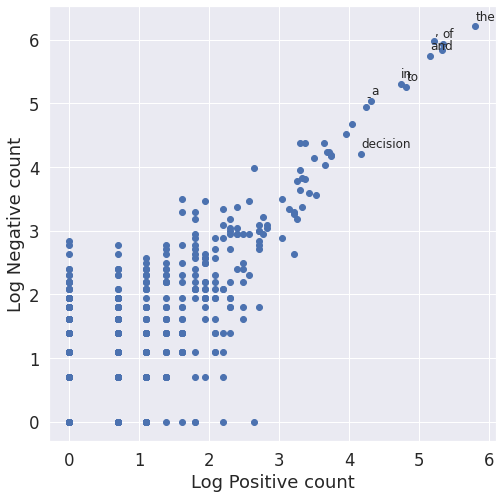

None

BY ps / 1 

     ps          text   ng
0   333           the  498
1   209            of  378
2   208             .  342
3   184             ,  393
4   174           and  313
5   124            to  193
6   115            in  202
7    75             a  154
8    70             -  141
9    65      decision   67
10   57            is  107
11   52           for   92
13   42        making   65
12   42  intelligence   66
14   41    artificial   69
15   40           are   69
16   39            on   56
17   38          this   80
18   34         based   35
19   33  optimization   63
20   31            by   36
21   29             )   80
22   29          with   45
23   28          that   46
24   28          data   29
27   27             (   80
25   27            as   52
26   27            an   38
29   26        system   44
28   26           can   24
30   25       process   27
31   25         model   14
32   25            be   26
33   23           ##s   28
34   21            it   33
35   21   

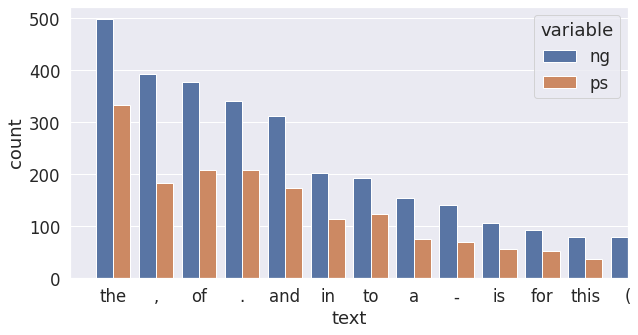

In [95]:
def sorte(x, reverse = True):
  return dict(sorted(x.items(), key=lambda item: item[1], reverse=reverse))

t_abstracts_ls = [scibert_tokenizer.tokenize(x) for x in t_abstracts]

print(t_labels.value_counts())
# Number of Words
all = {}
for ls in t_abstracts_ls:
  for x in ls:
    v = all.get(x, 0)
    all[x] = v+1


  # Number of Words of labels (0,1)

def table(all):
  all = {}
  for ls, y in zip(t_abstracts_ls, t_labels):
    for x in ls:
      v = all.get((x, y) , 0)
      all[(x, y)] = v+1

  ps = []
  ng = []
  
  for x in sorte(all):
    if x[1] == 1:
      ps.append(x)
    else:
      ng.append(x)
  

  print(f"{'Label: 1':^27} | {'Label: 0':^25}")
  print(f"{'-'*60:^50}")
  k = 0
  for x,y in zip(ps, ng):
    k+=1
    if k > 20: break;
    print(f"{x[0]:^15}: {all[x]:^10} | {y[0]:^15}: {all[y]:^9}")

  all = {}
  for ls, y in zip(t_abstracts_ls, t_labels):
    for x in ls:
      v = all.get((x, y) , 0)
      all[(x, y)] = v+1

  ps = []
  ng = []

  for x in sorte(all):
    if x[1] == 1:
      ps.append(x)
    else:
      ng.append(x)

  x = []
  x_text = []
  y = []
  y_text = []

  for ps ,ng in zip(ps, ng):
    x.append(all[ps])
    x_text.append(ps[0])
    
    y.append(all[ng])
    y_text.append(ng[0])

    # print([[x[0], y[0]], [x[1], y[1]], [ ,  all[y] ] ])

  p = pd.DataFrame({"ps": np.log(x), "text": x_text})
  n = pd.DataFrame({"ng": np.log(y), "text": y_text})
  
  ps = pd.DataFrame({"ps": x, "text": x_text})
  ng = pd.DataFrame({"ng": y, "text": y_text})


  data = pd.merge( p, n, on='text')
  dataN = pd.merge( ps, ng, on='text')

  fig, ax = plt.subplots(figsize = (8, 8))

  # np.log(data['ps'])

  # Plot a dot for each pair of words
  ax.scatter(data['ps'], data['ng'])  

  # assign axis labels
  plt.xlabel("Log Positive count")
  plt.ylabel("Log Negative count")

  # Add the word as the label at the same position as you added the points just before
  for i in range(0, 10):
      ax.annotate(data.loc[i,'text'], (data.loc[i,'ps'] , data.loc[i,'ng'] + 0.1 ), fontsize=12)

  # data.loc[2,'text']

  # ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.


  print(plt.show())
  print("\nBY ps / 1 \n")
  print(dataN.head(50).sort_values('ps', ascending=False))

  print("-----"*20)
  
  print("\n BY ng / 0 \n")
  print(dataN.head(50).sort_values('ng', ascending=False))
  print("-----"*20)
  
  dataN['sum'] = dataN['ps'] + dataN['ng']
  print("\n BY freq of word\n")
  print(dataN.head(50).sort_values('sum', ascending=False))

  data_melt = dataN.melt(id_vars = 'text', value_vars=['ps','ng'], value_name='count')

  sns.barplot(x="text", y="count", hue='variable', data=data_melt.sort_values('count', ascending=False).reset_index())
  plt.xlim(-1,12)

table(all)